In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 

In [2]:
fights = pd.read_csv('preprocessed_data.csv')
fights.head()

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.000000,0.0,0.420000,0.49500,0.330,0.36000,0.500000,1.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.500000,0.0,0.660000,0.30500,0.300,0.50000,1.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
2,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
3,Blue,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,0,0,1,0,0,0,0,0,1
4,Blue,False,0.125000,0.0,0.535625,0.57875,0.185,0.16625,0.125000,0.187500,...,0,1,0,0,0,0,1,0,0,0


In [3]:
fights['Winner'].value_counts()

Winner
Red     3979
Blue    1923
Name: count, dtype: int64

In [4]:
print(fights.isnull().sum())
fights.dropna(inplace=True)

Winner                  0
title_bout              0
B_avg_KD                0
B_avg_opp_KD            0
B_avg_SIG_STR_pct       0
                       ..
R_Stance_Open Stance    0
R_Stance_Orthodox       0
R_Stance_Sideways       0
R_Stance_Southpaw       0
R_Stance_Switch         0
Length: 160, dtype: int64


In [5]:
x, y = fights.loc[:,(fights.columns != "Winner")], fights["Winner"]

x_train , x_test , y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 42,stratify=y)

x_train , x_val , y_train, y_val = train_test_split(x_train,y_train, test_size = 0.25, random_state= 42,stratify=y_train)

In [6]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_val)

test_accuracy = accuracy_score(y_val,y_pred)
print(f"VALIDATION ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))



VALIDATION ACCURACY: 0.6808

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.18      0.27       385
           1       0.70      0.92      0.80       796

    accuracy                           0.68      1181
   macro avg       0.61      0.55      0.53      1181
weighted avg       0.64      0.68      0.63      1181


Confusion Matrix:
 [[ 71 314]
 [ 63 733]]


In [9]:
param_grid = {
    'n_estimators': [10, 100, 200, 300],  
    'max_depth': [3, 5, 10, 20, None],       
    'max_features':["sqrt", "log2", None],    
    'min_samples_leaf': [1, 2, 4],              
    'bootstrap': [True, False]  
}

rf_model = RandomForestClassifier(random_state=42)

grid_search =  GridSearchCV(rf_model,param_grid,cv=10,scoring="accuracy", n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

best_rf = grid_search.best_estimator_

print("best params:   ",grid_search.best_params_)
print("best score:    ", grid_search.best_score_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
best params:    {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 300}
best score:     0.6867231638418079


In [10]:
y_pred = best_rf.predict(x_test)

test_accuracy = accuracy_score(y_test,y_pred)

print(f"TEST ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

TEST ACCURACY: 0.6765

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.10      0.17       385
           1       0.69      0.95      0.80       796

    accuracy                           0.68      1181
   macro avg       0.60      0.53      0.48      1181
weighted avg       0.63      0.68      0.59      1181


Confusion Matrix:
 [[ 39 346]
 [ 36 760]]


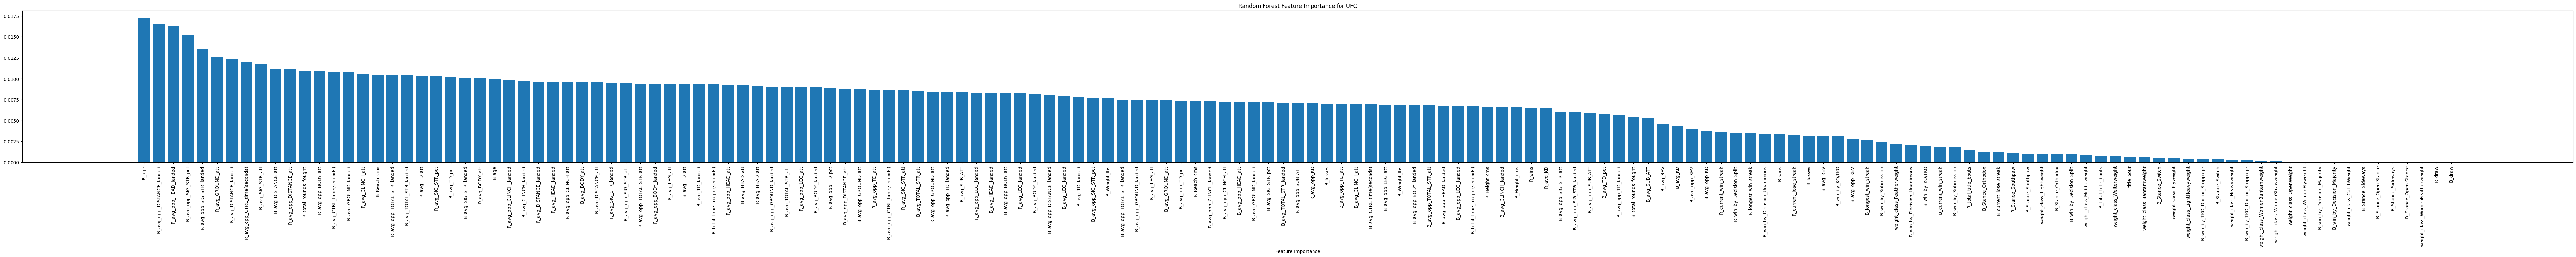

In [23]:
feature_importances = best_rf.feature_importances_
feature_names = x.columns

# Sort and plot
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(100, 6))

plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance for UFC")
plt.xticks(rotation=90)
plt.show()

In [26]:
print(fights['B_age'].mean())
print(fights['R_age'].mean())


29.28803795323619
29.57760081328363


In [28]:
print((fights['Winner'] == 'Blue').mean())
print((fights['Winner'] == 'Red').mean())

0.32582175533717384
0.6741782446628262


In [30]:
import pickle

# Save the model
with open('mma_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully!")

Model saved successfully!


In [32]:
df_useless_subset = fights[['Winner', 'R_draw', 'B_draw']].copy()
df_useless_subset.head()


,Winner,R_draw,B_draw
0,Red,0,0
1,Red,0,0
2,Red,0,0
3,Blue,0,0
4,Blue,0,0


In [34]:
x, y = df_useless_subset.loc[:,(df_useless_subset.columns != "Winner")], df_useless_subset["Winner"]

x_train , x_test , y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 42,stratify=y)

x_train , x_val , y_train, y_val = train_test_split(x_train,y_train, test_size = 0.25, random_state= 42,stratify=y_train)

In [35]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [36]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [37]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_val)

test_accuracy = accuracy_score(y_val,y_pred)
print(f"VALIDATION ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

VALIDATION ACCURACY: 0.6740

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       385
           1       0.67      1.00      0.81       796

    accuracy                           0.67      1181
   macro avg       0.34      0.50      0.40      1181
weighted avg       0.45      0.67      0.54      1181


Confusion Matrix:
 [[  0 385]
 [  0 796]]


d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [38]:
param_grid = {
    'n_estimators': [10, 100, 200, 300],  
    'max_depth': [3, 5, 10, 20, None],       
    'max_features':["sqrt", "log2", None],    
    'min_samples_leaf': [1, 2, 4],              
    'bootstrap': [True, False]  
}

rf_model = RandomForestClassifier(random_state=42)

grid_search =  GridSearchCV(rf_model,param_grid,cv=10,scoring="accuracy", n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

best_rf = grid_search.best_estimator_

print("best params:   ",grid_search.best_params_)
print("best score:    ", grid_search.best_score_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
best params:    {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 10}
best score:     0.6742937853107345


In [39]:
y_pred = best_rf.predict(x_test)

test_accuracy = accuracy_score(y_test,y_pred)

print(f"TEST ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

TEST ACCURACY: 0.6740

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       385
           1       0.67      1.00      0.81       796

    accuracy                           0.67      1181
   macro avg       0.34      0.50      0.40      1181
weighted avg       0.45      0.67      0.54      1181


Confusion Matrix:
 [[  0 385]
 [  0 796]]


d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\josef\UFC-Predictor-AICOMPONENT\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [40]:
from sklearn.utils import resample

# Separate winners
blue_wins = fights[fights['Winner'] == 'Blue']
red_wins = fights[fights['Winner'] == 'Red']

# Keep all blue wins, randomly sample same number of red wins
red_wins_sampled = red_wins.sample(n=len(blue_wins), random_state=42)

# Combine them
balanced_df = pd.concat([blue_wins, red_wins_sampled]).reset_index(drop=True)

# Verify
print(balanced_df['Winner'].value_counts())

Winner
Blue    1923
Red     1923
Name: count, dtype: int64


In [41]:
x, y = balanced_df.loc[:,(balanced_df.columns != "Winner")], balanced_df["Winner"]

x_train , x_test , y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 42,stratify=y)

x_train , x_val , y_train, y_val = train_test_split(x_train,y_train, test_size = 0.25, random_state= 42,stratify=y_train)

In [42]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [43]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [44]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_val)

test_accuracy = accuracy_score(y_val,y_pred)
print(f"VALIDATION ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))


VALIDATION ACCURACY: 0.5904

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.67      0.62       385
           1       0.61      0.51      0.55       384

    accuracy                           0.59       769
   macro avg       0.59      0.59      0.59       769
weighted avg       0.59      0.59      0.59       769


Confusion Matrix:
 [[258 127]
 [188 196]]


In [46]:
param_grid = {
    'n_estimators': [10, 100, 200, 300],  
    'max_depth': [3, 5, 10, 20, None],       
    'max_features':["sqrt", "log2", None],    
    'min_samples_leaf': [1, 2, 4],              
    'bootstrap': [True, False]  
}

rf_model = RandomForestClassifier(random_state=42)

grid_search =  RandomizedSearchCV(rf_model,param_grid,cv=10,scoring="accuracy",n_iter=100, n_jobs=-1,verbose=2,random_state=42)
grid_search.fit(x_train,y_train)

best_rf = grid_search.best_estimator_

print("best params:   ",grid_search.best_params_)
print("best score:    ", grid_search.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
best params:    {'n_estimators': 300, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best score:     0.6281065311500094


In [47]:
# Save the model
with open('fair_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully!")

Model saved successfully!


In [48]:
y_pred = best_rf.predict(x_test)

test_accuracy = accuracy_score(y_test,y_pred)

print(f"TEST ACCURACY: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

TEST ACCURACY: 0.5831

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61       385
           1       0.60      0.50      0.55       385

    accuracy                           0.58       770
   macro avg       0.59      0.58      0.58       770
weighted avg       0.59      0.58      0.58       770


Confusion Matrix:
 [[256 129]
 [192 193]]
